<img src="https://raw.githubusercontent.com/jdeldre/MAE150A/master/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**
<hr />

# Planar potential flows past stationary bodies
In this notebook, we'll take a look at how we can use distributions of singularities
to generate potential flows past stationary obstacles.

### Set up the module

In [1]:
using MAE150A

In [2]:
using PotentialFlow
using LinearAlgebra: diagm

In [3]:
using Plots

## Distributions of singularities
Suppose we want to model a solid surface in a potential flow.
The only role of that surface is to prevent fluid from going through it.
We can accomplish the same thing by replacing the surface with a
 **distribution of singularities**. We place a large number of singularities
 (e.g., source, vortices, or doublets) on the surface of the body, and solve for
  their strengths such that the no-flow-through condition is enforced.

Mathematically, we would use an infinite number of singularities, each with
vanishingly-small strength. But in practice, we can do very well by just using a
large number, and then enforcing the no-flow-through condition at these points.

This forms a linear algebra problem: **find the strengths of $N$ singularities
to enforce the no-flow-through condition at $N$ points.**

So the velocity at any point in the fluid is equal to the freestream plus the velocity induced by each of the $N$ point sources:

$$
\mathbf{u}(\mathbf{x}) = \mathbf{U}_\infty + \sum_{n = 1}^N \mathbf{u}_n(\mathbf{x})
$$

If we want enforce the no-flow-through condition at the point sources, then we must have

$$
\sum_{n = 1}^N \mathbf{n}_i \cdot \mathbf{u}_n(\mathbf{x}_i) = - \mathbf{n}_i \cdot \mathbf{U}_\infty \qquad \text{for } i = 1, 2, \cdots, N.
$$

As long as the we are not evaluating the velocity that a segment induces on itself, we will treat the segment as a point source:

$$
    \mathbf{u}_n(\mathbf{x})
  = \frac{Q_n }{2\pi}
    \frac{\mathbf{x} - \mathbf{x}_n}
         {|\mathbf{x} - \mathbf{x}_n|^2} \qquad \text{when } \mathbf{x} \neq \mathbf{x}_n
$$

But how **would** we evaluate $\mathbf{u}_n(\mathbf{x}_n)$?  We probably won't go over it in class,
so you'll just have to believe ([or not](#Or-Not)) that it is:

<a id="back"></a>

$$
\mathbf{n}_n \cdot \mathbf{u}_n(\mathbf{x}_n) = \frac{Q_n}{2\Delta s}
$$

So the no-flow-through condition above can be written in matrix form:

$$
\underbrace{
\begin{bmatrix}
\frac{1}{2\Delta s} & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_2}{|\mathbf{x}_1 - \mathbf{x}_2|^2}
& \cdots & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_N}{|\mathbf{x}_1 - \mathbf{x}_N|^2}
\\
\mathbf{n}_2 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_2 - \mathbf{x}_1}{|\mathbf{x}_2 - \mathbf{x}_1|^2} & \frac{1}{2\Delta s}
& & \vdots
\\
\vdots & & \ddots & \vdots \\
\mathbf{n}_N \cdot \frac{1}{2\pi}\frac{\mathbf{x}_N - \mathbf{x}_1}{|\mathbf{x}_N - \mathbf{x}_1|^2} &
\cdots & \cdots &
\frac{1}{2\Delta s}
\end{bmatrix}}_{A}
\begin{bmatrix}
Q_1 \\
Q_2 \\
\vdots \\
\vdots \\
Q_n
\end{bmatrix} =
\underbrace{ -
\begin{bmatrix}
\mathbf{n}_1 \cdot \mathbf{U}_\infty \\
\mathbf{n}_2 \cdot \mathbf{U}_\infty \\
\vdots \\
\vdots \\
\mathbf{n}_N \cdot \mathbf{U}_\infty \\
\end{bmatrix}}_{b},
$$

which we can solve to find the strengths of the point sources.

First, let us set up a uniform flow in the $x$ direction

In [4]:
U∞ = 1.0 + 0im
fs = Freestreams.Freestream(U∞)

PotentialFlow.Freestreams.Freestream(1.0 + 0.0im)

### Flow past a triangle
Let's start by considering flow past a equilateral triangle.
We will discretize this triangle into small segments, each with length $\Delta s$.

In [5]:
Δs = 0.1
z, n̂, Δslist = equilateraltriangle(0.0,Δs);

 We create `unit_sources` and `targets`. The `unit_sources` are the collection of point
 sources, whose strengths we need to determine. Here, we set all of their
strengths equal to 1. Their strengths will be the unknowns of a system of equations.

 The `targets` are the locations
 at which we want to enforce the no-flow-through condition. These are
 at the same places at the sources.

In [6]:
unit_sources = Source.Point.(z,1.0)
targets = Elements.position.(unit_sources);

Let's plot the sources and normals just to make sure it looks like what we want:

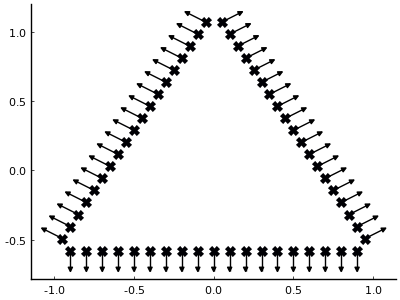

In [7]:
plot(unit_sources)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(unit_sources, markersize = 8)

The cross marks correspond to the center of each source, and the arrows correspond to the normal vectors along the surface.

Now let's solve for the source strengths. In the cell below we set up a system
of equations for these strengths, according to what we wrote above. You don't
need to worry much about the Julia-related syntax. Basically, we are creating
a matrix of elements (`A`) that correspond to the velocity induced at each target
location by each source (with strength equal to 1). The right-hand side
of the system of equations (`b`) is the negative of the normal component of
the uniform flow.

Then, we solve it. `Q` contains the solution: the strengths of all of the sources.

In [8]:
# The right-hand side
b = -dotproduct.(n̂, U∞)

# Form the matrix elements:
A = [dotproduct(n, induce_velocity(target, unit_source, 0)) for (n, target) in zip(n̂, targets), unit_source in unit_sources]
A .+= 0.5*diagm(0 => 1 ./ Δslist)

# And solve it...
Q = A \ b;
sources = Source.Point.(targets, Q);

Let's look at the sources now, with their correct strengths:

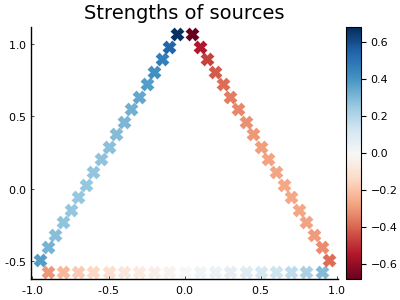

In [9]:
plot(sources, color = :RdBu, colorbar = :right, markersize = 10, title = "Strengths of sources")

You should notice that there are positive strengths (sources) near the side of the triangle
facing the flow, and negative strengths (sinks).

Let's now check the streamlines. We will release a set of fluid particles, as
we have done before. The starting locations are a collection of points
with complex coordinates:
a bunch of points along the left side of the obstacle

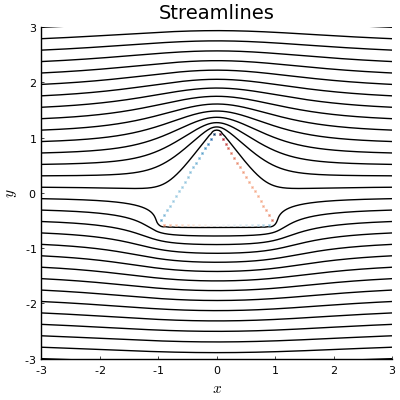

In [10]:
zstart = collect(-3.0 .+ range(-3,3,length=30)*im)

Tmax = 20
tx, ty = compute_trajectories((fs,sources),zstart,Tmax,Δt=0.01);


plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400), title = "Streamlines")
plot!(sources, markersize = 2, color = :RdBu)

#### Pressure distribution
Let's calculate the pressure distribution the surface of the object. We will need
the fluid velocity on the surface for this. To calculate this, we simply evaluate it at
all of the source locations. However, the source's effect on itself needs to be added
in explicitly. There is a function `surface_velocity` to do that work for us.

In [11]:
us = surface_velocity(targets,sources,fs,n̂,Δslist);

Now, the pressure can be obtained by applying the Bernoulli equation between two points,
one at a large distance away where we only have a uniform flow. The flow is steady and gravity
is ignored here, so this is just

$$ p = p_\infty + \frac{1}{2}\rho U_\infty^2 - \frac{1}{2}\rho |\mathbf{u}|^2 $$

The **pressure coefficient** is defined as the difference of the pressure from the ambient
pressure, normalized by the dynamic pressure in the uniform flow:

$$ C_p = \dfrac{p - p_\infty}{\frac{1}{2} \rho U_\infty^2} $$

Putting these two things together, the pressure coefficient is

$$ C_p = 1 - |\mathbf{u}|^2/U_\infty^2 $$

Remember that we are only interested here in the pressure at points on the surface, so
$\mathbf{u}$ is the surface velocity. Let's compute the pressure coefficient here. We will plot
it by coloring the source points with the local value of $C_p$.

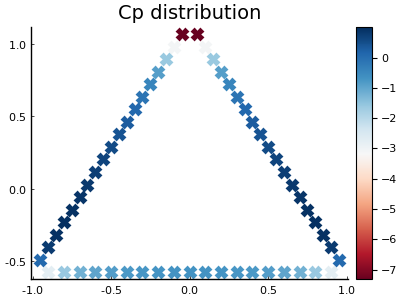

In [12]:
Cp = 1 .- dotproduct.(us,us)/dotproduct(U∞,U∞)
plot(sources, marker_z = Cp, color = :RdBu, colorbar = :right, markersize = 10, title = "Cp distribution")

Before moving on, we'll wrap all of our steps into a function so we don't have to keep
repeating ourselves. But we will add a little bit more functionality, too. There is no
reason we need to limit ourselves to just a uniform flow outside of our body. Maybe we want to
include, say, some vortices outside the body, too. They can all be included in the superposition:

$$
\mathbf{u}(\mathbf{x}) = \mathbf{u}_{\mathrm{other}} + \sum_{n = 1}^N \mathbf{u}_n(\mathbf{x})
$$

where $\mathbf{u}_{\mathrm{other}}$ is the sum of the velocity from *other elements*, like
uniform flow and vortices outside the body shape. If we want enforce the no-flow-through
condition at the point sources, then we just put all the elements with known values on
the right side:

$$
\sum_{n = 1}^N \mathbf{n}_i \cdot \mathbf{u}_n(\mathbf{x}_i) = - \mathbf{n}_i \cdot \mathbf{u}_{\mathrm{other}}(\mathbf{x}_i) \qquad \text{for } i = 1, 2, \cdots, N.
$$

There is a function `simulate_flow` that can do all of this for us. All of
the additional elements of the flow are included as an argument to the function,
including uniform flow.
The function sets up and solves the problem, then obtains the surface velocities,
pressures, and a collection of streamlines.

### Flow Past a Cylinder
We will now look at flows past a circular cylinder. This is a useful problem because
we already know what the flow should be, so we can check that everything works.

Same steps as before, but now with the `circle` function:

In [13]:
center = 0.0
r = 1.0
Δs = π/50
z, n̂, Δslist = circle(center,r,Δs)
unit_sources = Source.Point.(z, 1.0);
targets = Elements.position.(unit_sources);

Plot these to check that they are the way we want them:

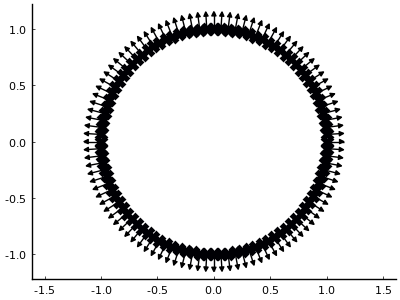

In [14]:
plot(unit_sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(unit_sources, markersize = 10)

Now we will use our `simulate_flow` function, providing the uniform flow as
the `other_elements` argument:

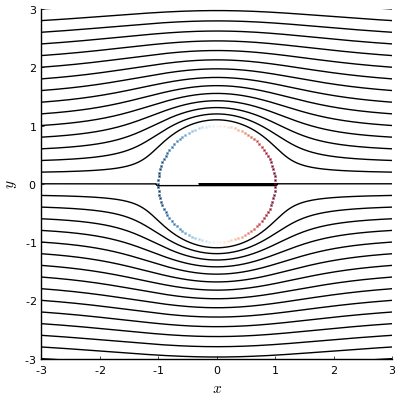

In [15]:
U∞ = 1.0+0im
other_elements = Freestreams.Freestream(U∞)
sources, us, Cp, tx, ty = simulate_flow(unit_sources, Δslist, n̂, other_elements)

plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(sources, markersize = 2, color = :RdBu)

Let's plot the pressure distribution on the shape.

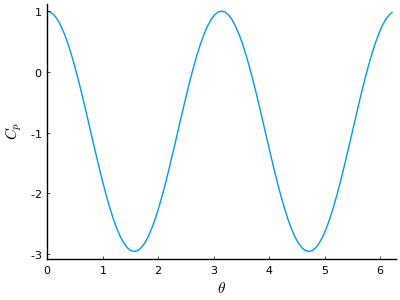

In [16]:
θ = range(0, 2π, length=length(Cp)+1)[1:end-1]
plot(θ,Cp,xlim=(0,2π),xlabel=L"\theta",ylabel=L"C_p")

This agrees with our expected result, $C_p(\theta) = 1 - 4\sin^2\theta$.

What is the total force on the body? That comes by integrating the pressure times the local normal:

$$ \mathbf{F} = -\int_{S} p\mathbf{n}\mathrm{d}A $$

This integral (non-dimensionalized by the reference dynamic pressure) is approximately
given by the **sum** over the surface pressure coefficients times normals times segment lengths:

In [17]:
F = -sum(Cp.*n̂.*Δslist)

-1.1934897514720433e-15 + 1.429412144204889e-15im

The force has very tiny values for both $F_x$ (the real part) and $F_y$ (the imaginary part).
This is **d'Alembert's paradox**. (But is this *always* the case for a potential flow past a
closed body?)

### Flow past an airfoil
In this example, we will compute the flow past an airfoil. NACA airfoils are a family
of airfoil shapes in which the camber and thickness can be independently chosen. For example,
NACA 4212 indicates an airfoil with 4% camber (the "4"), with maximum camber at location 20%
of the chord length (the "2"), and thickness 12% of the chord (the "12"). Symmetric members
of the family have the numbers 00xx.

In [18]:
targets = naca4(0.04,0.4,0.12,np=100);

Get the lengths and normals of each point

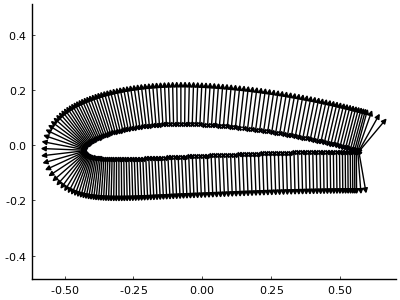

In [19]:
dt = 0.5*[diff(targets);0]
dz = dt + circshift(dt,1)
Δslist = abs.(dz)
n̂ = -im*dz./Δslist;

unit_sources = Source.Point.(targets, 1.0);

plot(unit_sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)

Now we will compute the flow at 5 degrees angle of attack. We do this by rotating
the uniform flow by 5 degrees:

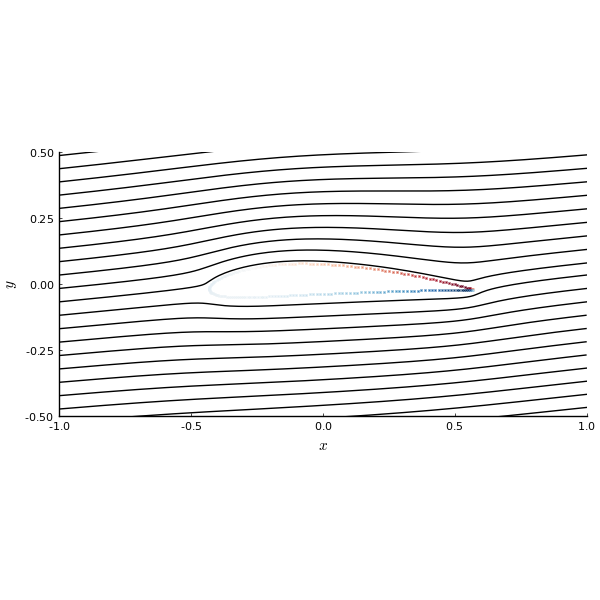

In [20]:
α = 5*π/180
U∞ = 1.0*exp(im*α)
other_elements = Freestreams.Freestream(U∞)
sources, us0, Cp, tx, ty = simulate_flow(unit_sources, Δslist, n̂, other_elements, tracer_start = collect(-3 .+ im*range(-1,0.5,length=31)));
plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-1, 1), ylim = (-0.5, 0.5), size = (600, 600), ratio=1)
plot!(sources, markersize = 2, color = :RdBu)

Let's look at the surface velocity on this airfoil. The plot below *unwraps* the
$x$ component of the surface velocity, plotting it from the top of the trailing edge,
then counterclockwise around the airfoil to the bottom of the trailing edge. Note
the big jump at the trailing edge (the first point and the last point in this plot).

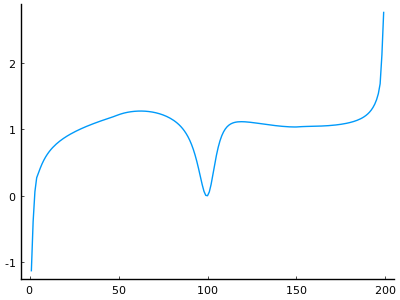

In [21]:
plot(real.(us0))

You might notice that the flow does not come smoothly off the trailing edge, evident
in the big jump in velocity there. In fact, we need to supply circulation about the airfoil
in just the right measure to make this flow come smoothly off. This condition of *smooth* flow
at the trailing edge is called the **Kutta condition**. This circulation is called the **bound
circulation** of the airfoil.

We will put a point vortex at the origin and determine the strength of this vortex so that
the condition is enforced. There are various ways to check the Kutta condition. An easy way
is to look at the jump in surface velocity at the points on either side of the trailing edge.
**When the difference between these values is minimum, the Kutta condition is enforced.**

In [22]:
U∞ = 1.0*exp(im*5*π/180)

0.9961946980917455 + 0.08715574274765817im

strength

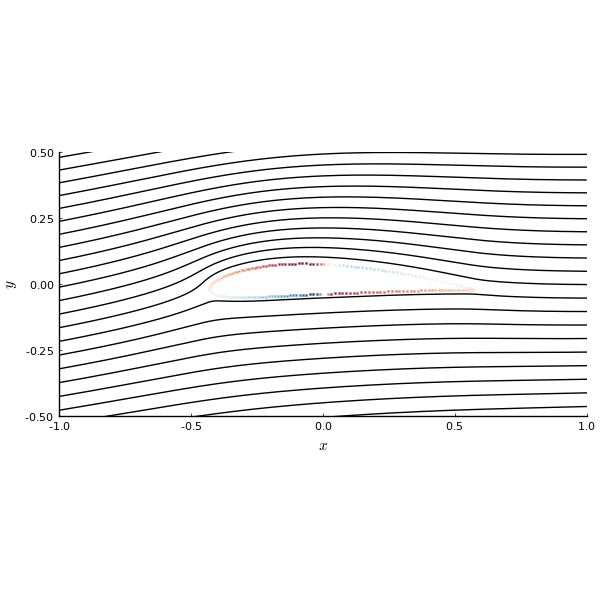

In [23]:
Γ = -0.583

other_elements = (Freestreams.Freestream(U∞),Vortex.Point(0+0im,Γ))
sources, us, Cp, tx, ty = simulate_flow(unit_sources, Δslist, n̂, other_elements, tracer_start = collect(-3 .+ im*range(-1,0.5,length=31)));

plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-1, 1), ylim = (-0.5, 0.5), size = (600, 600))
plot!(sources, markersize = 2, color = :RdBu,ratio=1)

Here is the jump in velocity at the trailing edge. We want this value to be as small
as possible.

In [24]:
abs(us[1]-us[end])

0.5944158886060774

Now let's plot the surface velocity again, comparing it with the original. There is
no more jump. (There is a small bump near the center, but this not really physical and
comes from using only a finite number of sources.

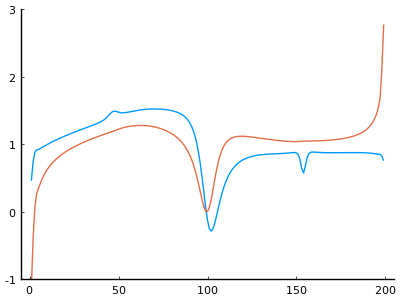

In [25]:
plot(real.(us),ylim=(-1,3))
plot!(real.(us0),ylim=(-1,3))

The force on the airfoil

In [26]:
F = -sum(Cp.*n̂.*Δslist)

-0.09858321436607602 + 1.1676191405946417im

There is both an $x$ and a $y$ component. The circulation only generates force perpendicular
to the free stream. But the free stream is at an angle, so the force itself is also at a
slight angle.

### Flow Past a Happy Face

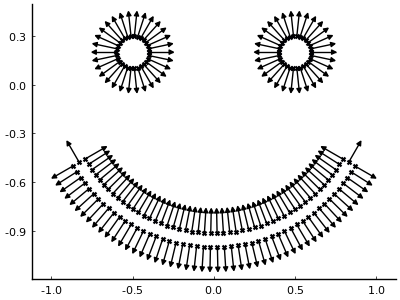

In [27]:
ns = 50
θ = range(π/6, 5π/6, length=ns)
Δs = step(θ)
targets = exp.(-im*θ)
n̂ = targets;
targets = vcat(targets, reverse((1 - 2Δs)*targets, 1))
n̂ = vcat(n̂, -reverse(n̂, 1))
#n̂[1] *= exp(im*π/4)
#n̂[ns] *= exp(-im*π/4)

dt = 0.5*[diff(targets);0]
dz = dt + circshift(dt,1)
Δslist = abs.(dz);

# Add points on the ends of the smile
push!(targets,0.5*(targets[1]+targets[2ns]))
push!(Δslist,2step(θ))
push!(n̂,n̂[1]*im)

push!(targets,0.5*(targets[ns]+targets[ns+1]))
push!(Δslist,2step(θ))
push!(n̂,-n̂[ns]*im)

θᵢ = range(0, 2π, length=31)[1:end-1]
left_eye = 0.1exp.(im*θᵢ) .- 0.5 .+ 0.2im
right_eye = 0.1exp.(im*θᵢ) .+ 0.5 .+ 0.2im;

append!(targets, left_eye)
append!(targets, right_eye)
append!(Δslist, fill(0.5π/length(θᵢ), 2length(θᵢ)))
append!(n̂, exp.(im*θᵢ))
append!(n̂, exp.(im*θᵢ))

unit_sources = Source.Point.(targets, 1.0);
plot(unit_sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)

With $U_\infty$ going downward:

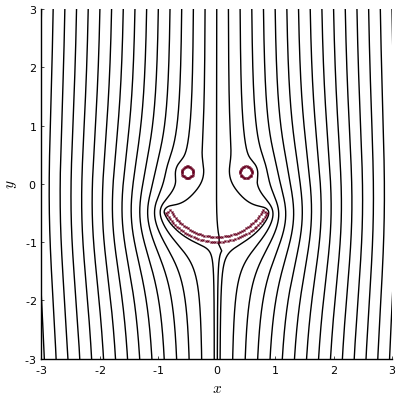

In [28]:
U∞ = 0.0-im
other_elements = Freestreams.Freestream(U∞)
sources, us, Cp, tx, ty = simulate_flow(unit_sources, Δslist, n̂, other_elements, tracer_start = collect(range(-3,3,length=31) .+ 3im),Δt = 0.0025)
plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(unit_sources, markersize = 2, color = :RdBu)

With $U_\infty$ from the side:

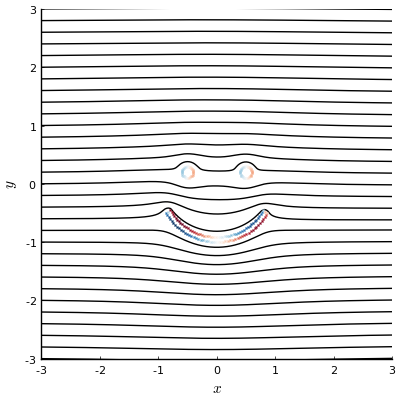

In [29]:
U∞ = 1.0+0im
other_elements = Freestreams.Freestream(U∞)
sources, us, Cp, tx, ty = simulate_flow(unit_sources, Δslist, n̂, other_elements)
plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(sources, markersize = 2, color = :RdBu)

## Appendix

### Or Not

We'll have to discuss source sheets for a little bit here to find out the velocity that the sheet induces on itself.
To keep it simple, we will use a straight sheet segment with length $\Delta s$ centered around the origin.
The equation describing this sheet segment is given by:

$$
\mathbf{u}_s(\mathbf{x}) = \frac{1}{2\pi}
\int_{-\Delta s/2}^{\Delta s/2}
\sigma(l) \frac{\mathbf{x} - \mathbf{x}_s(l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l,
$$

where $\sigma$ is the local strength of the sheet.
This is not all that different from the point sources, except when you approach the sheet.

We first assume that $\Delta s$ is small enough that $\sigma$ is essentially constant in the interval.
Then, if we parametrize the target point as

$$
\mathbf{x} = r\cos\theta\,\mathbf{i} + r\sin\theta\,\mathbf{j},
$$

we obtain

$$
\begin{align*}
\mathbf{u}_s(\mathbf{x})
& = \frac{\sigma(0)}{2\pi}
\left[ \mathbf{i}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{(r\cos\theta - l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l + \mathbf{j}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{r\cos\theta}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l
\right] \\
& =-\frac{\sigma(0)}{2\pi}
\left( \frac{\mathbf{i}}{2}
\log\left[ (r\cos\theta - l)^2 + (r\sin\theta)^2
\right]_{-\Delta s/2}^{\Delta s/2} + \left. \mathbf{j}
\tan^{-1 }\left(\frac{r\cos\theta - l}
{r\sin\theta}
\right)
\right|_{-\Delta s/2}^{\Delta s/2}
\right)
\end{align*}
$$

As $\mathbf{x}$ approaches the origin, $r$ goes to zero

$$
\lim_{r \rightarrow 0}
\mathbf{u}_s(\mathbf{x}) = \mathrm{sign}(\theta)\frac{\sigma(0)}{2}.
$$

Since we are using point sources to model a segment of a source sheet, its strength $S$ is distributed along the segment, i.e.

$$
S = \int_{-\Delta s/2}^{\Delta s/2} \sigma(l) \mathrm{d}l.
$$

For a short sheet segment, we assume that $\sigma$ is essentially constant along the segment, so we have $\sigma \approx \frac{S}{\Delta s}$, which finally gives us

\begin{equation}
\lim_{r \rightarrow 0} \mathbf{u}_s(\mathbf{x}) = \frac{S}{2\Delta s}
\end{equation}

You can go [back](#back) now.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*